<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
<a href="https://sebastianraschka.com">Sebastian Raschka</a> 撰写的 <a href="http://mng.bz/orYv">《从零构建大语言模型》</a> (Build a Large Language Model From Scratch) 书籍的补充代码<br>
<br>代码仓库：<a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第 5 章：在无标签数据上进行预训练

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.7
numpy version: 2.3.4
tiktoken version: 0.12.0
torch version: 2.9.0
tensorflow version: 2.20.0


- 在本章中，我们将实现用于预训练 LLM 的训练循环和基本模型评估代码
- 在本章的最后，我们将从 OpenAI 加载公开可用的预训练权重到我们的模型中

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/01.webp" width=500px>

- 本章涵盖的主题如下所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/02.webp" width=400px>

## 5.1 评估生成式文本模型

- 本节开始时，我们将简要回顾如何使用上一章的代码初始化 GPT 模型
- 然后，我们讨论 LLM 的基本评估指标
- 最后，在本节中，我们将这些评估指标应用于训练和验证数据集

### 5.1.1 使用 GPT 生成文本

- 我们使用上一章的代码初始化一个 GPT 模型

In [ ]:
import torch
from previous_chapters import GPTModel
# 如果本地没有 `previous_chapters.py` 文件，
# 你可以从 `llms-from-scratch` PyPI 包导入它。
# 详情请见：https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 例如：
# from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 词表大小
    "context_length": 256, # 缩短的上下文长度 (这也是原始长度: 1024)
    "emb_dim": 768,        # 嵌入维度
    "n_heads": 12,         # 注意力头数
    "n_layers": 12,        # 层数
    "drop_rate": 0.1,      # Dropout 率
    "qkv_bias": False      # Query-key-value 偏置
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # 在推理期间禁用 dropout

- 我们在上面使用了 0.1 的 dropout，但现在训练 LLM 时不使用 dropout 已经相对普遍了
- 现代 LLM 在查询、键和值矩阵的 `nn.Linear` 层中也不使用偏置向量（不同于早期的 GPT 模型），这是通过设置 `"qkv_bias": False` 来实现的
- 我们将上下文长度（`context_length`）减少到仅 256 个 token，以减少训练模型所需的计算资源，而原始的 1.24 亿参数 GPT-2 模型使用了 1024 个 token
  - 这样做是为了让更多的读者能够在他们的笔记本电脑上跟随并执行代码示例
  - 但是，请随意将 `context_length` 增加到 1024 个 token（这不需要任何代码更改）
  - 我们稍后还将从预训练权重加载一个 `context_length` 为 1024 的模型

- 接下来，我们使用上一章的 `generate_text_simple` 函数来生成文本
- 此外，我们定义了两个便捷函数 `text_to_token_ids` 和 `token_ids_to_text`，用于在本章中使用的 token 和文本表示之间进行转换

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/03.webp" width=500px>

In [ ]:
import tiktoken
from previous_chapters import generate_text_simple

# 或者：
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 添加 batch 维度
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # 移除 batch 维度
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 如上所示，模型并没有生成好的文本，因为它还没有经过训练
- 我们如何以数值形式衡量或捕捉什么是“好文本”，以便在训练期间对其进行跟踪？
- 下一小节将介绍计算生成输出的损失度量的指标，我们可以用它来衡量训练进度
- 接下来的微调 LLM 章节还将介绍衡量模型质量的其他方法

<br>

### 5.1.2 计算文本生成损失：交叉熵和困惑度

- 假设我们有一个 `inputs` 张量，其中包含 2 个训练示例（行）的 token ID
- 与 `inputs` 对应，`targets` 包含我们希望模型生成的期望 token ID
- 请注意，`targets` 是 `inputs` 向后移动 1 个位置的结果，正如我们在第 2 章实现数据加载器时所解释的那样

In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- 将 `inputs` 输入模型，我们获得 2 个输入示例的 logits 向量，每个示例包含 3 个 token
- 每个 token 都是一个 50,257 维的向量，对应于词表的大小
- 应用 softmax 函数，我们可以将 logits 张量转换为包含概率分数的相同维度的张量

In [ ]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # 词表中每个 token 的概率
print(probas.shape) # 形状: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- 下图使用一个非常小的词表进行说明，概述了我们如何将概率分数转换回文本，这我们在上一章末尾讨论过

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/04.webp" width=500px>

- 正如上一章所讨论的，我们可以应用 `argmax` 函数将概率分数转换为预测的 token ID
-上面的 softmax 函数为每个 token 生成了一个 50,257 维的向量；`argmax` 函数返回该向量中概率分数最高的位置，即给定 token 的预测 token ID

- 由于我们有 2 个输入 batch，每个 batch 包含 3 个 token，因此我们获得 2 x 3 个预测的 token ID：

In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 如果我们要解码这些 token，我们会发现它们与我们希望模型预测的 token（即目标 token）截然不同：

In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 这是因为模型还没有经过训练
- 要训练模型，我们需要知道它距离正确预测（目标）还有多远

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/06.webp" width=500px>

- 对应于目标索引的 token 概率如下：

In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 我们希望最大化所有这些值，使它们接近概率 1
- 在数学优化中，最大化概率分数的对数比最大化概率分数本身更容易；这超出了本书的范围，但我在此录制了一个更详细的讲座：[L8.2 逻辑回归损失函数](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [ ]:
# 计算所有 token 概率的对数
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 接下来，我们将计算平均对数概率：

In [ ]:
# 计算每个 token 的平均概率
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 我们的目标是通过优化模型权重，使这个平均对数概率尽可能大
- 由于使用了对数，最大可能值为 0，而我们目前距离 0 还很远

- 在深度学习中，通常的做法是最小化*负*平均对数概率值，而不是最大化平均对数概率；在我们的例子中，与其最大化 -10.7722 使其接近 0，在深度学习中，我们会最小化 10.7722 使其接近 0
- -10.7722 的负值，即 10.7722，在深度学习中也被称为交叉熵损失

In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- PyTorch 已经实现了一个 `cross_entropy` 函数来执行上述步骤

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/07.webp" width=400px>

- 在应用 `cross_entropy` 函数之前，让我们检查 logits 和 targets 的形状

In [ ]:
# Logits 形状 (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets 形状 (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 对于 PyTorch 中的 `cross_entropy` 函数，我们希望通过在 batch 维度上合并这些张量来将它们展平：

In [13]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 注意，targets 是 token ID，这也代表了 logits 张量中我们希望最大化的索引位置
- PyTorch 中的 `cross_entropy` 函数会自动处理 softmax 的应用和内部对 logits 中那些需要最大化的 token 索引的对数概率计算

In [14]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 与交叉熵损失相关的一个概念是 LLM 的困惑度（Perplexity）
- 困惑度仅仅是交叉熵损失的指数

In [15]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- 困惑度通常被认为更具可解释性，因为它可以被理解为模型在每一步不确定的有效词汇量大小（在上面的例子中，即 48,725 个单词或 token）
- 换句话说，困惑度提供了一种衡量标准，说明模型预测的概率分布与数据集中单词的实际分布匹配程度如何
- 与损失类似，较低的困惑度表示模型预测更接近实际分布

### 5.1.3 计算训练集和验证集的损失

- 我们使用一个相对较小的数据集来训练 LLM（实际上，只有一个短篇故事）
- 理由如下：
  - 你可以在几分钟内在笔记本电脑上运行代码示例，而无需合适的 GPU
  - 训练完成得相对较快（几分钟而不是几周），这对教育目的很有好处
  - 我们使用公共领域的文本，可以将其包含在这个 GitHub 仓库中，而不会违反任何使用权或导致仓库体积过大


- 例如，Llama 2 7B 需要在 A100 GPU 上花费 184,320 个 GPU 小时来训练 2 万亿个 token
  - 在撰写本文时，AWS 上一台 8xA100 云服务器的小时成本约为 30 美元
  - 因此，通过粗略计算，训练这个 LLM 将花费 184,320 / 8 * 30 美元 = 690,000 美元
 
- 下面，我们使用与第 2 章相同的数据集

In [ ]:
import os
import requests

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


# 本书最初使用了下面的代码
# 但是，urllib 使用的旧协议设置可能会导致
# 使用 VPN 的读者遇到问题。
# 上面的 `requests` 版本在这方面更加健壮。

        
# import os
# import urllib.request

# file_path = "the-verdict.txt"
# url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# if not os.path.exists(file_path):
#     with urllib.request.urlopen(url) as response:
#         text_data = response.read().decode('utf-8')
#     with open(file_path, "w", encoding="utf-8") as file:
#         file.write(text_data)
# else:
#     with open(file_path, "r", encoding="utf-8") as file:
#         text_data = file.read()

- 通过打印前 99 个和最后 99 个字符，快速检查文本是否加载正常

In [ ]:
# 前 99 个字符
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [ ]:
# 最后 99 个字符
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [19]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- 只有 5,145 个 token，对于训练 LLM 来说，这段文本非常短，但同样，这是出于教育目的（我们稍后还将加载预训练权重）

- 接下来，我们将数据集分为训练集和验证集，并使用第 2 章中的数据加载器为 LLM 训练准备 batch
- 为了便于可视化，下图假设 `max_length=6`，但对于训练加载器，我们将 `max_length` 设置为 LLM 支持的上下文长度
- 为简单起见，下图仅显示输入 token
    - 由于我们训练 LLM 来预测文本中的下一个单词，因此 targets 看起来与这些 inputs 相同，只是 targets 向后移动了一个位置

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/09.webp" width=500px>

In [ ]:
from previous_chapters import create_dataloader_v1
# 或者：
# from llms_from_scratch.ch02 import create_dataloader_v1

# 训练/验证比率
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
# 健全性检查

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("训练加载器没有足够的 token。"
          "尝试降低 `GPT_CONFIG_124M['context_length']` 或 "
          "增加 `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("验证加载器没有足够的 token。"
          "尝试降低 `GPT_CONFIG_124M['context_length']` 或 "
          "减少 `training_ratio`")

- 我们使用相对较小的 batch size 来减少计算资源需求，这也是因为数据集本身就很小
- 例如，Llama 2 7B 训练时的 batch size 为 1024

- 可选检查，确认数据加载正确：

In [22]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 另一个可选检查，确认 token 大小在预期范围内：

In [23]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 接下来，我们将实现一个实用函数来计算给定 batch 的交叉熵损失
- 此外，我们实现第二个实用函数来计算数据加载器中用户指定数量的 batch 的损失

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 如果 num_batches 超过数据加载器中的 batch 总数，
        # 则将 batch 数减少到与数据加载器中的 batch 总数相匹配
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- 如果你的机器有支持 CUDA 的 GPU，LLM 将在 GPU 上训练，无需更改任何代码
- 通过 `device` 设置，我们确保数据加载到与 LLM 模型相同的设备上

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # 使用 PyTorch 2.9 或更高版本获得稳定的 mps 结果
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")


print(f"Using {device} device.")


model.to(device) # nn.Module 类不需要赋值 model = model.to(device)


torch.manual_seed(123) # 由于数据加载器中的洗牌，为了可重复性设置种子

with torch.no_grad(): # 为了效率禁用梯度跟踪，因为我们还未开始训练
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using mps device.
Training loss: 10.987583054436577
Validation loss: 10.98110580444336


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/10.webp" width=400px>

## 5.2 训练 LLM

- 在本节中，我们终于实现了训练 LLM 的代码
- 我们专注于一个简单的训练函数（如果你有兴趣使用更高级的技术（如学习率预热、余弦退火和梯度裁剪）来增强此训练函数，请参阅[附录 D](../../appendix-D/01_main-chapter-code)）

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # 初始化列表以跟踪损失和看到的 token
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 主训练循环
    for epoch in range(num_epochs):
        model.train()  # 将模型设置为训练模式
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 重置上一次 batch 迭代的损失梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 计算损失梯度
            optimizer.step() # 使用损失梯度更新模型权重
            tokens_seen += input_batch.numel()
            global_step += 1

            # 可选评估步骤
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 在每个 epoch 后打印示例文本
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # 紧凑的打印格式
    model.train()

- 现在，让我们使用上面定义的训练函数来训练 LLM：

In [ ]:
# 注意：
# 取消注释以下代码以计算执行时间
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# 注意：
# 取消注释以下代码以显示执行时间
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.817, Val loss 9.924
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.332
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.619, Val loss 7.042
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.596
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.524, Val loss 6.508
Ep 3 (Step 000025): Train loss 5.369, Val loss 6.378
Every effort moves you, and to the of the of the picture. Gis.                                     
Ep 4 (Step 000030): Train loss 4.830, Val loss 6.263
Ep 4 (Step 000035): Train loss 4.586, Val loss 6.285
Every effort moves you of the "I the picture.                    "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.879, Val loss 6.130
Every effort moves you know he had been his pictures, and I felt it's by his last word.          

- 注意，你的计算机上获得的损失值可能会略有不同，如果它们大致相似（训练损失低于 1，验证损失低于 7），则无需担心
- 微小的差异通常是由于不同的 GPU 硬件和 CUDA 版本或较新 PyTorch 版本中的微小变化引起的
- 即使你在 CPU 上运行该示例，你也可能会观察到微小的差异；产生差异的一个可能原因是 `nn.Dropout` 在不同操作系统上的行为不同，这取决于 PyTorch 是如何编译的，正如 [PyTorch 问题跟踪器上的此处](https://github.com/pytorch/pytorch/issues/121595) 所讨论的那样

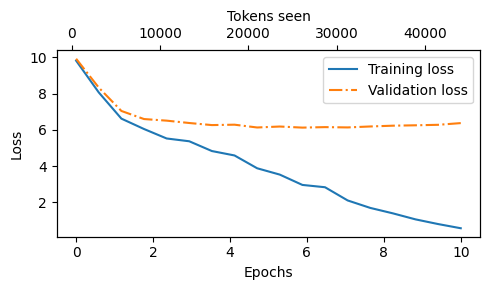

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 绘制训练和验证损失随 epoch 的变化
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # 仅在 x 轴上显示整数标签

    # 为看到的 token 创建第二个 x 轴
    ax2 = ax1.twiny()  # 创建一个共享相同 y 轴的第二个 x 轴
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 用于对齐刻度的不可见图
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # 调整布局以腾出空间
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 观察上面的结果，我们可以看到模型开始时生成的是难以理解的单词串，而在最后，它能够产生语法上或多或少正确的句子
- 然而，基于训练集和验证集的损失，我们可以看到模型开始过拟合
- 如果我们检查它在最后写的一些段落，我们会发现它们逐字包含在训练集中——它只是记住了训练数据
- 随后，我们将介绍可以在一定程度上减轻这种记忆的解码策略
- 请注意，这里的过拟合是因为我们有一个非常非常小的训练集，并且我们对它进行了多次迭代
  - 这里的 LLM 训练主要用于教育目的；我们主要想看看模型能否学会产生连贯的文本
  - 我们稍后将加载预训练权重，而不是花费数周或数月的时间在昂贵的硬件上针对大量数据训练此模型

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/13.webp" width=350px>

**If you are interested in augmenting this training function with more advanced techniques, such as learning rate warmup, cosine annealing, and gradient clipping, please refer to [Appendix D](../../appendix-D/01_main-chapter-code)**

**如果你对更大的训练数据集和更长的训练运行时间感兴趣，请参阅 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**

## 5.3 控制随机性的解码策略

- 对于像我们上面训练的 GPT 模型这样相对较小的 LLM，推理成本相对较低，所以如果你在上面使用 GPU 进行训练，在推理时也没必要使用 GPU
- 使用我们之前在简单训练函数中使用的 `generate_text_simple` 函数（来自上一章），我们可以一次生成一个单词（或 token）的新文本
- 正如第 5.1.2 节所解释的那样，下一个生成的 token 是词表中所有 token 中概率分数最大的 token

In [ ]:
# 新增：这里使用 CPU，因为对于这个模型来说推理成本很低
# 并且为了确保读者在本书的剩余部分
# 获得相同的结果
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




- 即使我们多次执行上面的 `generate_text_simple` 函数，LLM 也总是会生成相同的输出
- 我们现在介绍两个概念，即所谓的解码策略，来修改 `generate_text_simple`：*温度缩放（temperature scaling）*和 *top-k* 采样
- 这些将允许模型控制生成文本的随机性和多样性

### 5.3.1 温度缩放 (Temperature scaling)

- 以前，我们总是使用 `torch.argmax` 采样概率最高的 token 作为下一个 token
- 为了增加多样性，我们可以使用 `torch.multinomial(probs, num_samples=1)` 从概率分布中采样下一个 token
- 在这里，每个索引被选中的机会对应于它在输入张量中的概率

- 下面简要回顾一下生成下一个 token 的过程，假设使用一个非常小的词表用于说明目的：

In [ ]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# 假设输入是 "every effort moves you"，并且 LLM
# 返回下一个 token 的以下 logits：
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# 下一个生成的 token 如下：
print(inverse_vocab[next_token_id])

forward


In [31]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


- 我们不使用 `torch.argmax` 来确定最可能的 token，而是使用 `torch.multinomial(probas, num_samples=1)` 通过从 softmax 分布中采样来确定最可能的 token
- 出于说明目的，让我们看看使用原始 softmax 概率对下一个 token 进行 1,000 次采样时会发生什么：

In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # 为了可重复性设置手动种子
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


- 我们可以通过一个称为温度缩放（temperature scaling）的概念来控制分布和选择过程
- “温度缩放”只是一个花哨的词，意思是将 logits 除以一个大于 0 的数
- 大于 1 的温度将导致应用 softmax 后的 token 概率分布更加均匀
- 小于 1 的温度将导致应用 softmax 后的分布更加自信（更尖锐或更陡峭）

- 请注意，根据你的操作系统，生成的 dropout 输出看起来可能会有所不同；你可以在 [PyTorch 问题跟踪器上的此处](https://github.com/pytorch/pytorch/issues/121595) 阅读有关这种不一致性的更多信息

In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# 温度值
temperatures = [1, 0.1, 5]  # 原始、更高置信度、更低置信度

# 计算缩放后的概率
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

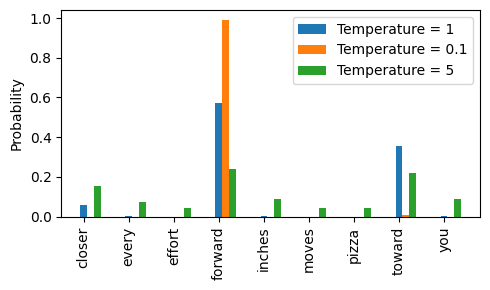

In [ ]:
# 绘图
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'温度 = {T}')

ax.set_ylabel('概率')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- 我们可以看到，通过温度 0.1 进行的缩放导致了更尖锐的分布，接近于 `torch.argmax`，使得最可能的单词几乎总是被选中：

In [35]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


- 通过温度 5 缩放的概率分布更加均匀：

In [36]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- 假设 LLM 输入为："every effort moves you"，使用上述方法有时会产生无意义的文本，例如 "every effort moves you pizza"，发生概率为 3.2%（1000 次中有 32 次）

### 5.3.2 Top-k 采样

- 为了能够使用更高的温度来增加输出的多样性，并减少出现无意义句子的概率，我们可以将采样 token 限制为前 k 个最可能的 token：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/15.webp" width=500px>

- （请注意，此图中的数字已被截断为小数点后两位，以减少视觉混乱。Softmax 行中的值加起来应为 1.0。）

- 在代码中，我们可以按如下方式实现：

In [37]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [38]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> 注意：
>
>  前一个代码单元格的一种替代的、稍微更高效的实现如下：
>
> ```python
> new_logits = torch.full_like( # create tensor containing -inf values
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into the -inf tensor
> ```
> <br>
> 更多详情请见： https://github.com/rasbt/LLMs-from-scratch/discussions/326

In [39]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 修改文本生成函数

- 前两个小节介绍了温度采样和 top-k 采样
- 让我们使用这两个概念来修改第 4 章中的 `generate_text_simple` 函数，创建一个新的 `generate` 函数：

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For 循环与之前相同：获取 logits，并仅关注最后一个时间步
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 新增：使用 top_k 采样过滤 logits
        if top_k is not None:
            # 仅保留 top_k 值
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # 新增：应用温度缩放
        if temperature > 0.0:
            logits = logits / temperature

            # 新增（书中未提及）：获得 mps 设备上等效结果的数值稳定性技巧
            # 在 softmax 之前减去行最大值
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # 应用 softmax 以获取概率
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 从分布中采样
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 否则与之前相同：获取具有最高 logits 值的词汇表条目的索引
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # 如果遇到序列结束 token 且指定了 eos_id，则提前停止生成
            break

        # 与之前相同：将采样索引追加到运行序列中
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [41]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand," she down." For Mrs. Gisburn! The women had


## 5.4 在 PyTorch 中加载和保存模型权重

- 训练 LLM 的计算成本很高，因此能够保存和加载 LLM 权重至关重要

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/16.webp" width=400px>

- PyTorch 中推荐的方法是保存模型权重，即所谓的 `state_dict`，方法是对 `.state_dict()` 方法应用 `torch.save` 函数：

In [42]:
torch.save(model.state_dict(), "model.pth")

- 然后我们可以按如下方式将模型权重加载到新的 `GPTModel` 模型实例中：

In [43]:
model = GPTModel(GPT_CONFIG_124M)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

- 通常使用自适应优化器（如 Adam 或 AdamW）而不是常规 SGD 来训练 LLM
- 这些自适应优化器为每个模型权重存储额外的参数，因此如果我们计划稍后继续预训练，那么保存它们是有意义的：

In [44]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [45]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 加载 OpenAI 的预训练权重

- 之前，出于教育目的，我们仅使用非常短的短篇小说书训练了一个小型 GPT-2 模型
- 有兴趣的读者也可以在 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg) 中找到在完整的古腾堡计划书籍语料库上进行的更长的预训练运行
- 幸运的是，我们不必花费数万到数十万美元在大型预训练语料库上预训练模型，而是可以加载 OpenAI 提供的预训练权重

---

---


⚠️ **注意：某些用户在本节中可能会因 TensorFlow 兼容性问题而遇到问题，尤其是在某些 Windows 系统上。此处 TensorFlow 仅用于加载原始 OpenAI GPT-2 权重文件，然后我们将这些文件转换为 PyTorch。如果您遇到与 TensorFlow 相关的问题，可以使用下面的替代代码代替本节中的其余代码。**
此替代方案基于预转换的 PyTorch 权重，使用上一节中描述的相同转换过程创建。详情请参阅笔记本：
[../02_alternative_weight_loading/weight-loading-pytorch.ipynb](../02_alternative_weight_loading/weight-loading-pytorch.ipynb)

```python
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
else:
    device = torch.device("cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
```

---

---

- 首先，一些样板代码用于从 OpenAI 下载文件并将权重加载到 Python 中
- 由于 OpenAI 使用了 [TensorFlow](https://www.tensorflow.org/)，我们将不得不安装并使用 TensorFlow 来加载权重；[tqdm](https://github.com/tqdm/tqdm) 是一个进度条库
- 取消注释并运行下一个单元格以安装所需的库

In [46]:
# pip install tensorflow tqdm

In [47]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.20.0
tqdm version: 4.67.1


In [ ]:
# 从该文件夹中包含的 gpt_download.py 进行相对导入

from gpt_download import download_and_load_gpt2
# 或者：
# from llms_from_scratch.ch05 import download_and_load_gpt2

---

**注意**

- 在极少数情况下，上面的代码单元格可能会导致 `zsh: illegal hardware instruction python` 错误，这可能是由于你机器上的 TensorFlow 安装问题
- 一位读者发现通过 `conda` 安装 TensorFlow 解决了这个特定情况下的问题，如 [此处](https://github.com/rasbt/LLMs-from-scratch/discussions/273#discussioncomment-12367888) 所述
- 你可以在这个补充的 [Python 设置教程](https://github.com/rasbt/LLMs-from-scratch/tree/main/setup/01_optional-python-setup-preferences#option-2-using-conda) 中找到更多说明

---

- 然后我们可以按如下方式下载 1.24 亿参数模型的模型权重：

In [49]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [ ]:
print("设置:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [ ]:
print("参数字典键:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
print(params["wte"])
print("Token 嵌入权重张量维度:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- 或者，"355M"、"774M" 和 "1558M" 也是支持的 `model_size` 参数
- 这些不同大小的模型之间的差异总结在下图中：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/17.webp" width=500px>

- 上面，我们将 124M GPT-2 模型权重加载到了 Python 中，但是我们仍然需要将它们传输到我们的 `GPTModel` 实例中
- 首先，我们初始化一个新的 GPTModel 实例
- 请注意，原始 GPT 模型在多头注意力模块中为查询、键和值矩阵初始化了带偏置向量的线性层，这不是必需的或推荐的；但是，为了能够正确加载权重，我们也必须在我们的实现中通过将 `qkv_bias` 设置为 `True` 来启用它们
- 我们还使用了原始 GPT-2 模型使用的 `1024` token 上下文长度

In [ ]:
# 在字典中定义模型配置以使其紧凑
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# 复制基本配置并使用特定模型设置进行更新
model_name = "gpt2-small (124M)"  # 示例模型名称
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- 下一个任务是将 OpenAI 权重分配给我们 `GPTModel` 实例中相应的权重张量

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [55]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- 如果模型加载正确，我们可以使用它来使用我们之前的 `generate` 函数生成新文本：

In [56]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




- 我们知道我们正确加载了模型权重，因为模型可以生成连贯的文本；如果我们犯了一个小错误，模型就无法做到这一点

- 有关从 Hugging Face Hub 加载权重的替代方法，请参阅 [../02_alternative_weight_loading](../02_alternative_weight_loading)
- 如果你有兴趣了解 GPT 架构与 Llama 架构（Meta AI 开发的一种流行 LLM）的比较，请参阅 [../07_gpt_to_llama](../07_gpt_to_llama) 中的奖励内容

## 总结和要点

- 请参阅 [./gpt_train.py](./gpt_train.py) 脚本，这是一个自包含的训练脚本
- [./gpt_generate.py](./gpt_generate.py) 脚本加载来自 OpenAI 的预训练权重并根据提示生成文本
- 你可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到练习解答